The Piotroski F-Score is often used by value investors to avoid the so-called value trap, that is, the trap of buying cheap stocks that are only cheap because they are in trouble.
The Piotroski F-Score is a composite factor comprising multiple sub-factors. It is calculated as the sum of 9 true/false criteria, resulting in a possible score of 0-9. Points are awarded as follows:

- Profitability:
    * 1 point if return on assets (ROA) is positive in the current year
    * 1 point if operating cash flow is positive in the current year
    * 1 point if ROA is higher in the current period than in the previous year
    * 1 point if cash flow from operations to total assets is higher than ROA (quality of earnings, accruals)
- Leverage, Liquidity and Source of Funds:
    * 1 point if long term debt is lower in the current period than in the previous year (decreased leverage, change in long-term leverage ratio)
    * 1 point if current ratio is higher in the current period than in the previous year (more liquidity)
    * 1 point if no new shares were issued in the last year (lack of dilution, change in the number of shares)
- Operating Efficiency:
    * 1 point if gross margin is higher in the current period than in the previous year
    * 1 point if asset turnover ratio is higher in the current period than in the previous year

In [79]:
import nasdaqdatalink as quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sharadar import equity_prices, fundamental_signal
from scipy.stats import normaltest, shapiro, skewtest, kurtosistest
import statsmodels.api as sm

In [26]:
quandl.ApiConfig.api_key = 'NRvcyMwNMXZ2ooDSM3nw'
universe = quandl.get_table('SHARADAR/SP500', action='historical', date='2022-12-31')

In [27]:
fundamentals = quandl.get_table('SHARADAR/SF1', datekey={'gte':'2022-07-31','lte':'2022-12-31'}, dimension="ART", ticker=",".join(universe['ticker'].to_list()))
fundamentals = fundamentals.drop_duplicates("ticker", keep="first")
fundamentals['roa'] = fundamentals['netinc'] / fundamentals['assets']
fundamentals['ocf'] = fundamentals['ebit'] - fundamentals['depamor'] - fundamentals['taxliabilities']
fundamentals['accruals'] = fundamentals['ocf'] - fundamentals['netinc']

In [29]:
p_fundamentals = quandl.get_table('SHARADAR/SF1', datekey={'gte':'2021-07-31','lte':'2021-12-31'}, dimension="ART", ticker=",".join(universe['ticker'].to_list()))
p_fundamentals = p_fundamentals.drop_duplicates("ticker", keep="first")
p_fundamentals = fundamental_signal.operating_margin(p_fundamentals)
p_fundamentals['roa'] = p_fundamentals['netinc'] / p_fundamentals['assets']

In [31]:
fundamentals = pd.merge(left=fundamentals, right=p_fundamentals, left_on="ticker", right_on="ticker", how="inner", suffixes=('', '_p'))
fundamentals["roa_change"] = fundamentals["roa"] - fundamentals["roa_p"]
fundamentals["de_change"] = fundamentals["de"] - fundamentals["de_p"]
fundamentals["currentratio_change"] = fundamentals["currentratio"] - fundamentals["currentratio_p"]
fundamentals["dilution"] = fundamentals["sharesbas"] - fundamentals["sharesbas_p"]
fundamentals["grossmargin_change"] = fundamentals["grossmargin"] - fundamentals["grossmargin_p"]
fundamentals["assetturnover_change"] = fundamentals["assetturnover"] - fundamentals["assetturnover_p"]

In [34]:
signals = fundamentals[["ticker", "calendardate", "datekey", "roa", "ocf", "roa_change", "accruals", "de_change", "currentratio_change", "dilution", "grossmargin_change", "assetturnover_change"]]
signals.loc[:, "score"] = 0
signals.loc[:, "score"] = signals["score"] + (signals["roa"] > 0)
signals.loc[:, "score"] = signals["score"] + (signals["ocf"] > 0)
signals.loc[:, "score"] = signals["score"] + (signals["roa_change"] > 0)
signals.loc[:, "score"] = signals["score"] + (signals["accruals"] > 0)
signals.loc[:, "score"] = signals["score"] + (signals["de_change"] < 0)
signals.loc[:, "score"] = signals["score"] + (signals["currentratio_change"] > 0)
signals.loc[:, "score"] = signals["score"] + (signals["dilution"] < 0)
signals.loc[:, "score"] = signals["score"] + (signals["grossmargin_change"] > 0)
signals.loc[:, "score"] = signals["score"] + (signals["assetturnover_change"] > 0)

In [59]:
signals.sort_values("score", ascending=False)
signals.head()

,ticker,calendardate,datekey,roa,ocf,roa_change,accruals,de_change,currentratio_change,dilution,grossmargin_change,assetturnover_change,score
0,ZTS,2022-09-30,2022-11-03,0.151163,1.742000e+09,0.006544,-3.250000e+08,0.004,-2.267,-7053827,0.003,0.028,6
1,ZION,2022-09-30,2022-11-03,0.009449,9.750000e+08,-0.004140,1.390000e+08,7.481,NaN,-6845709,0.000,-0.006,4
2,ZBRA,2022-09-30,2022-11-01,0.062836,2.170000e+08,-0.081239,-2.510000e+08,0.720,-0.061,-1811693,-0.017,-0.137,3
3,ZBH,2022-09-30,2022-11-02,0.013027,-1.667000e+09,-0.021099,-1.944900e+09,-0.147,0.168,944384,-0.007,0.000,3
4,YUM,2022-09-30,2022-11-08,0.222184,1.993000e+09,-0.023493,7.090000e+08,0.140,-0.240,-11445237,-0.001,0.053,5


In [76]:
print(signals["score"].mean())
print(signals["score"].std())
print(signals["score"].skew())
# Negative skewness, the tail is more pronouced on the left rather than the right side.
# Most of the values end up being right of the mean. The most extreme values are found further to the left.
# You can expect some small gains here and there but you can generally expect to see a few large losses here and there as an investor.
print(signals[signals["score"] < signals["score"].mean()].shape)
print(signals[signals["score"] > signals["score"].mean()].shape)
print(signals["score"].kurt())
print(signals["score"].kurtosis())
# Platykurtic (kurtosis < 3.0). These types of distributions have short tails (fewer outliers.)
# Platykurtic distributions have demonstrated more stability than other curves because extreme price movements rarely occured in the past.


4.855421686746988
1.7451227588776912
-0.07602193387251252
(209, 13)
(289, 13)
-0.2975972396753819
-0.2975972396753819


In [80]:
# One of the most common assumptions for statistical tests is that the data used are normally distributed.
# For example, if you want to run a t-test or an ANOVA, you must first test whether the data or variables are normally distributed.
# The assumption of normal distribution is also important for linear regression analysis, but in this case it is important that the error made by the model is normally distributed, not the data itself.
# The test rejects the hypothesis of normality when the p-value is less than or equal to 0.05.
# Failing the normality test allows you to state with 95% confidence the data does not fit the normal distribution.
print(skewtest(signals["score"]))
print(kurtosistest(signals["score"]))
print(normaltest(signals["score"]))
# The function tests the null hypothesis that a sample comes from a normal distribution.
# It is based on D'Agostino and Pearson's that combines skew and kurtosis to produce an omnibus test of normality
# statistic is s^2 + k^2, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest
# p-value is smaller than 0.05? No. Normal distribution is assumed.

SkewtestResult(statistic=-0.6995884479762048, pvalue=0.4841843589404966)
KurtosistestResult(statistic=-1.5172013809398857, pvalue=0.12921584777934247)
NormaltestResult(statistic=2.7913240268676507, pvalue=0.24766902186370035)


In [65]:
shapiro(signals["score"])
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

ShapiroResult(statistic=0.9692857265472412, pvalue=1.0480296630532848e-08)

<Axes: >

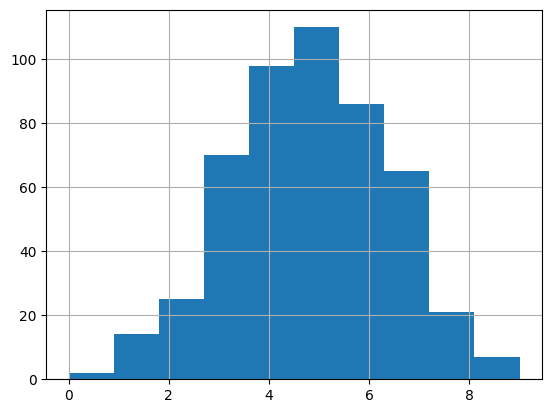

In [61]:
signals["score"].hist()

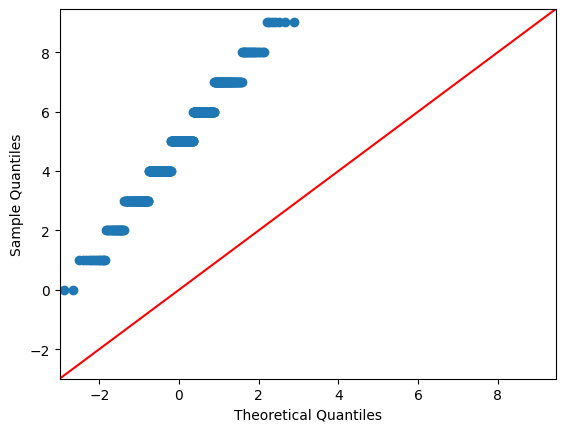

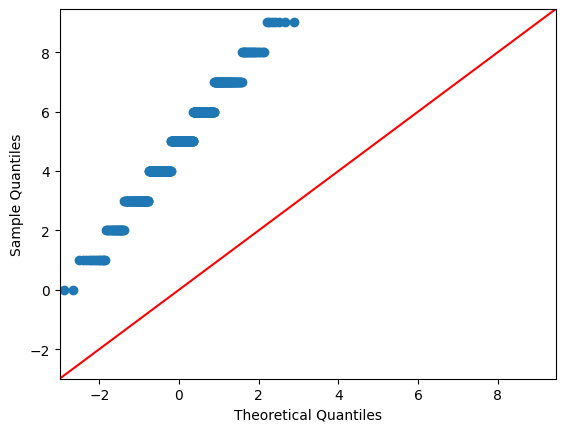

In [68]:
sm.qqplot(signals["score"], line="45")
# Sample Quantiles have a tendency to be higher than Theoretical Quantiles

In [ ]:
# As mentioned above, Joseph Piotroski originally proposed the F-Score as a quality filter to be applied on top of a value screen.
# That is, an investor would select a basket of cheap stocks, then apply the F-Score to weed out the low-quality stocks within that subset.

In [ ]:
# Zipline is built on top of Python's scientific computing libraries, most importantly numpy and pandas. These libraries are highly optimized and are themselves written in compiled languages.
# Although C# is natively fast, it lacks a comparable ecosystem of scientific packages.